The challenges for directly using SSM in the DRL is:
- the unobservable state is not known when using the SSM for planning. For example, how to know the interior/exterior wall temperature for the RC model if it is used for planning?

In [78]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import gymnasium as gym
import numpy as np
import random
import os
import pandas as pd
from typing import Callable
from collections import deque
import matplotlib 
matplotlib.use('Agg')

In [79]:
# Test if interpolaiton is differentiable in jax.numpy
t = np.arange(10)
y = t**2 + 3*t

interp = jnp.interp(9.5, t, y) 

f = lambda x: jnp.interp(x, t, y)
grad_fcn = jax.value_and_grad(f)
grad_fcn(0.)
grad_fcn(0.5)


(Array(2., dtype=float32), Array(4., dtype=float32, weak_type=True))

In [80]:
"""
class SimpleDense(nn.Module):
  features: int
  kernel_init: Callable = nn.initializers.lecun_normal()
  bias_init: Callable = nn.initializers.zeros_init()

  @nn.compact
  def __call__(self, inputs):
    kernel = self.param('kernel',
                        self.kernel_init, # Initialization function
                        (inputs.shape[-1], self.features))  # shape info.
    y = lax.dot_general(inputs, kernel,
                        (((inputs.ndim - 1,), (0,)), ((), ())),) # TODO Why not jnp.dot?
    bias = self.param('bias', self.bias_init, (self.features,))
    y = y + bias
    return y
"""
class LSSM(nn.Module):
    state_dim: int 
    action_dim: int
    disturbancce_dim: int
    output_dim: int
    dt: float 

    initializer: Callable = nn.initializers.lecun_normal()
    @nn.compact
    def __call__(self, x, u, d):
      """
      x: (b, state_dim)
      u: (b, action_dim)
      d: (b, disturbance_dim)
      """
      A = self.param('A',
                      self.initializer, # initialization
                      (self.state_dim, self.state_dim)) # shape
      Bu = self.param('Bu',
                      self.initializer, # initialization
                      (self.state_dim, self.action_dim))
      Bd = self.param('Bd',
                      self.initializer,
                      (self.state_dim, self.disturbancce_dim))

      C = self.param('C',
                      self.initializer,
                      (self.output_dim, self.state_dim))
      D = self.param("D",
                      self.initializer,
                      (self.output_dim, self.action_dim))
      xdot = jnp.dot(x, A.T) + jnp.dot(u, Bu.T) + jnp.dot(d, Bd.T)

      x_next = xdot * self.dt + x
      y_next = jnp.dot(x_next, C.T) + jnp.dot(u, D.T)
      
      return xdot, x_next, y_next

lssm = LSSM(state_dim=3, action_dim=1, disturbancce_dim=4, output_dim=2, dt=900.)

key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)
x = jax.random.uniform(key1, (3,3))
u = jnp.array([[0.],[0.],[0.]])
d = jax.random.uniform(key1, (3,4))
params = lssm.init(key2, x, u, d)
xdot, x_next, y_next = lssm.apply(params, x, u, d)
xdot
x_next
y_next

Array([[ 155.16179, -288.31546],
       [ 657.3522 , -125.37837],
       [ 373.0937 , -112.1631 ]], dtype=float32)

In [81]:
# say we have an extact model of the system
A = np.array([[-1.97402551e-04,  0.00000000e+00,  1.92610415e-04],
              [0.00000000e+00, -3.30784418e-06,  2.00281620e-06],
              [1.51360733e-06,  7.56564853e-07, -2.27017218e-06]])
Bu = np.array([[9.63095932e-05], [0.], [0.]])
Bd = np.array([[4.79213586e-06, 9.63095932e-05, 0.00000000e+00, 0.00000000e+00],
               [1.30502798e-06, 0.00000000e+00, 2.00353963e-06, 0.00000000e+00],
               [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.56838127e-07]])
C = np.array([[1., 0., 0.],
              [0., 0., 0.]])
D = np.array([[0.],
              [1.]])

ABCD = {'A': A, 'Bu': Bu, 'Bd': Bd, 'C': C, 'D': D}
exact_model_params = {"params": ABCD}

# define the system
x0 = np.array([19,36,25])
u = 0
d = np.array([0,0,0,0])
dt = 900

# simulate the system
lssm = LSSM(state_dim=3, action_dim=1, disturbancce_dim=4, output_dim=2, dt=dt)
lssm.apply(exact_model_params, x0, u, d)


(Array([[ 1.0646121e-03, -6.9011992e-05, -7.5943058e-07]], dtype=float32),
 Array([[19.95815 , 35.93789 , 24.999317]], dtype=float32),
 Array([[19.95815,  0.     ]], dtype=float32))

In [82]:
class QNetwork(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(2)(x)
        return x

# we will not learn an environment model here instead we provide an ideal model
#class EnvModel(nn.Module):
#    @nn.compact
#    def __call__(self, x):
#        x = nn.Dense(256)(x)
#        x = nn.relu(x)
#        x = nn.Dense(256)(x)
#        x = nn.relu(x)
#        x = nn.Dense(256)(x)
#        x = nn.relu(x)
#        x = nn.Dense(3)(x)  # 3 outputs: 2 states [Tz for next step and power for next step] (although we have simple relationship between power and control action), and reward
#        return x

In [83]:
import env
# RC model parameters
rc_params = [6.9789902e+03, 2.1591113e+04, 1.8807944e+05, 3.4490612e+00, 4.9556872e-01, 9.8289281e-02, 4.6257420e+00]
x0 = np.array([20, 35.8, 26.])
x_high = np.array([40., 80., 40.])
x_low = np.array([10., 10., 10.])
n_actions = 101
u_high = [0]
u_low = [-10.0] # -12

# load disturbances
file_path = os.path.abspath('')
parent_path = os.path.dirname(file_path)
data_path = os.path.join(parent_path, 'data/disturbance_1min.csv')
data = pd.read_csv(data_path, index_col=[0])
# assign time index
t_base = 181*24*3600 # 7/1
n = len(data)
index = range(t_base, t_base + n*60, 60)
data.index = index

# sample
dt = 900
data = data.groupby([data.index // dt]).mean()
index_dt = range(t_base, t_base + len(data)*dt, dt)
data.index = index_dt 

# get disturbances for lssm
t_d = index_dt
disturbance_names = ['out_temp', 'qint_lump', 'qwin_lump', 'qradin_lump']
disturbance = data[disturbance_names].values

# RC Gym envionment
ts = 195*24*3600
ndays = 1
te = ndays*24*3600 + ts
weights = [100., 1., 0.] # for energy cost, dT, du
cop = 1.0 

env = gym.make("R4C3Discrete-v0",
            rc_params = rc_params,
            x0 = x0,
            x_high = x_high,
            x_low = x_low,
            n_actions = n_actions,
            u_high = u_high,
            u_low = u_low,
            disturbances = (t_d, disturbance),
            cop = cop,
            ts = ts,
            te = te,
            dt = dt,
            weights = weights).env

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

/opt/conda/lib/python3.8/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [84]:
random.seed(41)

# Hyperparameters
learning_rate = 1e-5
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.9
episodes = 50
batch_size = 64
planning_steps = 5
 
q_network = QNetwork()
env_model = LSSM(state_dim=3, action_dim=1, disturbancce_dim=4, output_dim=2, dt=dt)

params = q_network.init(jax.random.PRNGKey(0), jnp.zeros((state_dim,)))
env_model_params = exact_model_params

optimizer = optax.adam(learning_rate)
env_model_optimizer = optax.adam(learning_rate)

opt_state = optimizer.init(params)
#env_model_opt_state = env_model_optimizer.init(env_model_params)

#@jax.jit
def q_learning_update(params, opt_state, state, action, reward, next_state, done):
    def loss_fn(params):
        q_values = q_network.apply(params, state)
        next_q_values = q_network.apply(params, next_state)
        target = reward + gamma * jnp.max(next_q_values, axis=1) * (1 - done)
        loss = jnp.mean((q_values[jnp.arange(q_values.shape[0]), action] - target) ** 2)
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# env model update 
#@jax.jit
def env_model_update(env_model_params, env_model_opt_state, state, action, next_state, reward):

    def env_model_loss_fn(env_model_params):

        state_action = jnp.hstack([state, action.reshape(-1,1)])#, axis=1
        # predictions of Tz and Power
        predictions = env_model.apply(env_model_params, state_action)
        # target is next Tz and power
        Tz_target = next_state[:,1]
        power_target = next_state[:,4]
        
        target = jnp.stack([Tz_target, power_target, reward], axis=1)
        print(target.shape, predictions.shape)
        print("in model update")
        env_model_loss = jnp.mean(jnp.square(predictions - target))
        return env_model_loss

    env_model_loss, env_model_grads = jax.value_and_grad(env_model_loss_fn)(env_model_params)
    env_model_updates, env_model_opt_state = env_model_optimizer.update(env_model_grads, env_model_opt_state)
    env_model_params = optax.apply_updates(env_model_params, env_model_updates)
    return env_model_params, env_model_opt_state


def get_objective_batch(t, Tz, P, env):
    t = t.astype(jnp.int32)
    h = (t%86400/3600).astype(jnp.int32)

    price = env.energy_price
    Tz_ub = env.Tz_high
    Tz_lb = env.Tz_low 

    price_batch = jnp.array([price[i] for i in h])
    cost_batch = price_batch*P*env.dt/3600.
    Tz_high_batch = jnp.array([Tz_ub[i] for i in h])
    Tz_low_batch = jnp.array([Tz_lb[i] for i in h])

    dTz = jnp.fmax(Tz - Tz_high_batch, Tz_low_batch - Tz)
    dTz = jnp.fmax(dTz, 0)

    du = 0

    return -(env.weights[0]*cost_batch + env.weights[1]*dTz + env.weights[2]*du)

buffer_size = 200000
memory = deque(maxlen=buffer_size)
reward_history = []
reward_threshold=175 # env.spec.reward_threshold
solved_window = 100

for episode in range(episodes):
    state, _ = env.reset(seed=1)
    done = False
    total_reward = 0
    step_in_episode = 0

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_values = q_network.apply(params, jnp.expand_dims(jnp.array(state), axis=0))
            action = jnp.argmax(q_values).item()

        next_state, reward, done, _, _ = env.step(action)

        # should it be env.t or env.t-dt?
        memory.append((env.t, state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        step_in_episode += 1

        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            #t_batch = jnp.array([t for (t, _, _, _, _, _) in batch])
            state_batch = jnp.array([s for (_, s, _, _, _, _) in batch])
            action_batch = jnp.array([a for (_, _, a, _, _, _) in batch])
            reward_batch = jnp.array([r for (_, _, _, r, _, _) in batch])
            next_state_batch = jnp.array([ns for (_, _, _, _, ns, _) in batch])
            done_batch = jnp.array([d for (_, _, _, _, _, d) in batch], dtype=jnp.float32)

            params, opt_state = q_learning_update(params, opt_state, state_batch, action_batch, reward_batch, next_state_batch, done_batch)
            # model learning: since we're using perfect env model, this is not needed.
            #env_model_params, env_model_opt_state = env_model_update(env_model_params, env_model_opt_state, state_batch, action_batch, next_state_batch, reward_batch)

            for _ in range(planning_steps):
                planning_batch = random.sample(memory, batch_size)
                t_batch = jnp.array([t for (t, _, _, _, _, _) in planning_batch])
                state_batch = jnp.array([s for (_, s, _, _, _, _) in planning_batch]) # random sample for states
                # random actions for exploration
                # choose from previously observed actions
                # action_batch = jnp.array([a for (_, a, _, _, _) in batch]) # random sample for actions
                # choose from action space
                action_batch = jnp.array([random.choice(range(action_dim)) for _ in range(batch_size)])
                # disctete action to control inputs
                control_batch = jnp.array([action/(env.n_actions-1)*(env.u_high - env.u_low) + env.u_low for action in action_batch])
                
                #state_action_batch = jnp.concatenate([state_batch, action_batch[:, np.newaxis]], axis=1)
                disturbance_batch = env.dist_fcn.evaluate(t_batch)
                
                # DRL state batch to model state batch
                model_state_batch = state_batch[:, 1:4] # [Tz, Twe, Twi]
                _, x_predictions, y_predictions = env_model.apply(env_model_params, model_state_batch, control_batch, disturbance_batch)
                # next_state_batch, reward_batch = env_model.apply(env_model_params, state_action_batch)
                # reconstruct next-state batch
                next_state_batch = jnp.array([ns for (_, _, _, _, ns, _) in planning_batch])
                next_state_batch = jnp.concatenate([next_state_batch[:,0].reshape(-1,1), x_predictions, next_state_batch[:,4:6], -y_predictions[:,1].reshape(-1,1), next_state_batch[:,7:]], axis=1)
                
                # reconstruct reward batch: we avoid du in objective, otherwise we have to save previous action in memeory
                Tz = y_predictions[:,0]
                P = -y_predictions[:,1]
                
                reward_batch = get_objective_batch(t_batch, Tz, P, env)
                
                done_batch = jnp.full(reward_batch.shape, False, dtype=jnp.float32)
                #done_batch = (jnp.abs(jnp.sum(next_state_batch - state_batch, axis=1)) > 0.5).astype(jnp.float32)

                params, opt_state = q_learning_update(params, opt_state, state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
        # episode stopping: NOT IMPLEMENTED.

    epsilon = max(epsilon * epsilon_decay, 0.01)
    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    # outputs
    reward_history.append(total_reward)

    # stop training if average reward reaches requirement
    # Calculate the average reward over the last 'solved_window' episodes
    if episode >= solved_window:
        avg_reward = np.mean(reward_history[-solved_window:])
        print(f'Episode: {episode}, Average Reward: {avg_reward}')

        if avg_reward >= reward_threshold:
            print(f"R4C3Discrete-v0 solved in {episode} episodes!")
            break
 


env is reset!
Episode 1, Total Reward: -767.1467750000003
env is reset!
Episode 2, Total Reward: -992.0400749999998
env is reset!
Episode 3, Total Reward: -1150.4030999999998
env is reset!
Episode 4, Total Reward: -984.1319499999997
env is reset!
Episode 5, Total Reward: -1068.6859249999998
env is reset!
Episode 6, Total Reward: -1309.3206750000002
env is reset!


KeyboardInterrupt: 

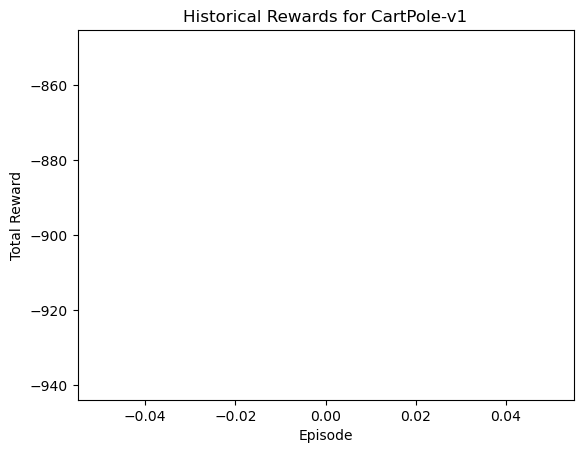

In [ ]:
import matplotlib.pyplot as plt
# Plot the historical rewards
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Historical Rewards for CartPole-v1")
plt.show()

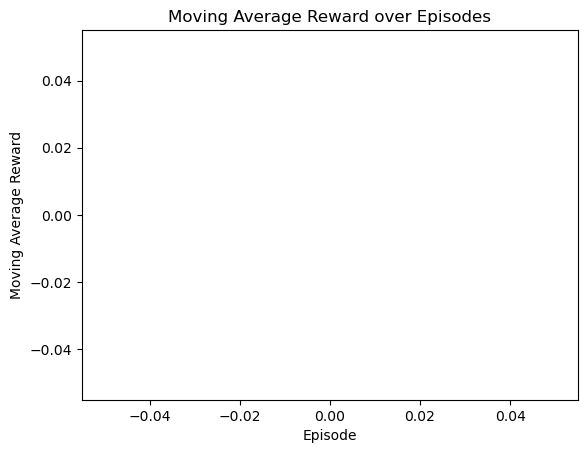

In [ ]:
# plot training 
def plot_moving_average_reward(episode_rewards, window_size=100):
    cumsum_rewards = np.cumsum(episode_rewards)
    moving_avg_rewards = (cumsum_rewards[window_size:] - cumsum_rewards[:-window_size]) / window_size

    plt.plot(moving_avg_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('Moving Average Reward over Episodes')
    plt.show()

plot_moving_average_reward(reward_history)

In [ ]:
# Test the trained agent

print("\nTesting the trained agent...")
state, _ = env.reset()
state = jnp.array(state, dtype=jnp.float32)

total_reward = 0
done = False
pre_screen = env.render()
step_in_episode = 0
actions = []
Tz = [state[1]]
P = [state[6]]
To = [state[4]]


while not done:
    q_values = q_network.apply(params, jnp.expand_dims(jnp.array(state), axis=0))
    action = jnp.argmax(q_values).item()
    #action = agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    next_state = jnp.array(next_state, dtype=jnp.float32)
    state = next_state
    total_reward += reward
    step_in_episode += 1

    # save for future use
    actions.append(action)
    Tz.append(next_state[1])
    P.append(next_state[6])
    To.append(next_state[4])
    
print(f"Total Reward: {total_reward}")

env.close()



Testing the trained agent...
env is reset!
Total Reward: -1777.5637762116105


1


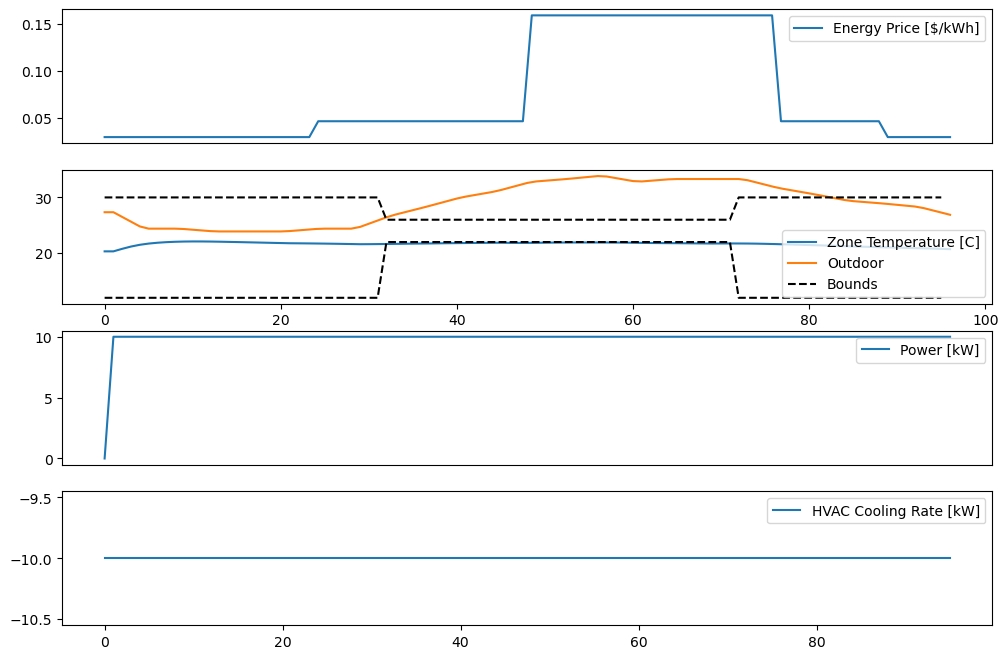

In [ ]:
n_days = step_in_episode*dt // (3600*24)
n_steps_per_hour = 3600 // dt
prices = env.energy_price
Tub = env.Tz_high
Tlb = env.Tz_low


# need make sure the length of Tub and Tlb is the same as Tz
prices = np.tile(prices.reshape(-1,1), (n_days, n_steps_per_hour))
Tub = np.tile(np.array(Tub).reshape(-1, 1), (n_days, n_steps_per_hour)) 
Tlb = np.tile(np.array(Tlb).reshape(-1, 1), (n_days, n_steps_per_hour)) 
# actions to actual cooling rate 
actions = [action/(n_actions-1)*(np.array(u_high) - np.array(u_low)) + np.array(u_low) for action in actions]

print(n_days)
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(prices.flatten(), label='Energy Price [$/kWh]')
plt.xticks([])
plt.legend() 

plt.subplot(4,1,2)
plt.plot(Tz, label='Zone Temperature [C]')
plt.plot(To, label="Outdoor")
plt.plot(Tub.flatten(), 'k--', label='Bounds')
plt.plot(Tlb.flatten(), 'k--')
plt.legend()

plt.subplot(4,1,3)
plt.plot(P, label="Power [kW]")
plt.xticks([])
plt.legend()

plt.subplot(4,1,4)
plt.plot(actions, label="HVAC Cooling Rate [kW]")
plt.legend()
plt.savefig('dqn-rc-LSSM.png')